CMSC858D --- HW1 --- Succinct Data Structures and Operations
========================================

*Fatemeh Almodaresi , SID:<117000986>*


# Introduction
Succinct operations, specifically rank and select over bit-vectors are important in helping with time and space efficiency 
of memory and time critical softwares working with terabytes of data.
They operate over a set of bits.For a bit-vector *bv* with size *bv.size*, *Rank1(idx)* for *0<=idx<bv.size*
returns the number of *1*s until index `idx` inclusive and *Rank0(idx)* returns number of *0*s in the same range.
Select operation can be counted as the inverse of rank where *select1(v)* for *1<=v<=Rank1(bv.size)* returns the index of the *v*th *1* in *bv*.
To apply rank and select operations in a world with alphabets more than only *0* and *1*, one of the very popular
and practical data structures are the Wavelet trees. Wavelet trees are binary perfectly balanced trees
that index a text consisting of alphabet in set $\sigma$ to a set of *0* and *1*s so that operations such as rank of the character *c*
and select of character *c*, $c \in \sigma$, can be reduced to a bunch of bit-vector rank and select operations.


In this homework, we were supposed to implement rank and select operations for an already existing bit-vector in tasks 1 and 2
and later, use these operations in querying a wavelet tree data structure that we have constructed, stored to, and later loaded from the disk.

All code has been implemented in C++14 and is available in the CMake-based project repository "*https://github.com/fataltes/cmsc858_hw1.git*".
I have used a slightly modified version of the `compact bit-vector` package from "*https://github.com/gmarcais/compact_vector.git*" as the underlying bit-vector data structure.

This report only contains the abstract overview of the implementation and the reports and plots.

The installation process is the typical cmake, build process. The least required cmake version is *3.9*
and I have compiled all the codes using gcc version *5.5*.

The main command available is `>bvOperators` and later we can add options and sub-commands to see the results for different tasks.

Note: In general, the main challenge in coding in C++ is handling memory, being careful about bounds, dangling pointers, bad allocs, segfaults, and things like that. I think initializing a project from scratch in C++ which should be a reasonably well-structures and working one was also another interesting challenge.[^1]





---------------
[^1]: P.S. Although I tried to catch a couple special cases with an invalid input
such as querying for a character that does not exist in the alphabet of wavelet tree,
Unfortunately, for the sake of time-limitation for this homework I was not able to manage all the
specific flaws in the input arguments such as a wrong file format, a non-existing directory, etc.
However, these verifications are in the todo list of this project in the future.

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from decimal import Decimal

# Task1
In this task, I implemented a rank data structure over the compact::bitvector structure.
The rank data structure itself consists of three bit-vectors, $R_s$, $R_b$, and $R_p$. I tried the version that
trades off time for space? so I will store $R_p$ as well which is $\mathcal{O}(log(log(n))*log(n)*2^{log(n)})$ extra space,
but reduces the time to just the constant time required to have a couple look-ups over the three bit-vectors
rather than at the point of the blocks, walking them until we find the desired value/index.
The following are the average time required per rank query for various sizes of bit-vectors,
where $\frac{1}{10}$th of each bit-vector bits are set and also the overhead size of the rank data structure for each sample.

### Rank Operation VS Bit-vector Size
-------
99 experiments
* starting from bv of size 10Mb
* with size change step of 1Mb
* stopping at bv of size 1Bb

Every 10 bit was set to 1. In this way, although the bit set pattern is uniform (which makes the bv construction fast), however it should cover a various sorts of touches on $R_s$, $R_b$, and $R_p$ BVs as well as guaranteeing that a similar percentage of the bv is set in all the experiments and the only factor different is the size. 

In [27]:
rankstat = pd.read_csv("/mnt/scratch1/fatemeh/courses/cmsc858/hw1/samples/rank.stat", sep="\t", 
                       dtype={'bv_size':np.int32, 'rank_size':np.int32, 'avg_rank_time':np.float64});
print('total # of experiments: {}'.format(len(rankstat)))
rankstat.head()

total # of experiments: 99


,bv_size,rank_size,avg_rank_time
0,10000000,5608832,6.550100e-08
1,20000000,10400896,4.459930e-08
2,30000000,15294144,4.461580e-08
3,40000000,20448320,4.301270e-08
4,50000000,25579072,4.206760e-08


(-1e-09, 1e-07)

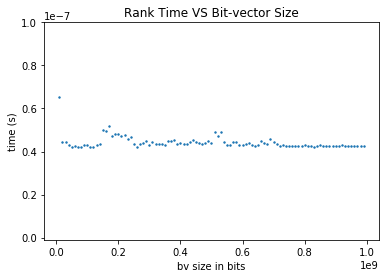

In [39]:
plt.figure(figsize=(6,4))
plt.scatter(rankstat['bv_size'], rankstat['avg_rank_time'], s=2)
plt.title('Rank Time VS Bit-vector Size')
plt.xlabel('bv size in bits')
plt.ylabel('time (s)')
plt.ylim((-0.000000001, 0.0000001))

As you can see in the next plot, the rank bv size changes close to the bv size but smaller (the definition of small_o)

Text(0, 0.5, 'rank bv size in bits (log)')

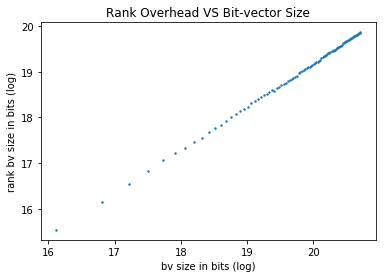

In [40]:
plt.figure(figsize=(6,4))
plt.scatter(np.log(rankstat['bv_size']), np.log(rankstat['rank_size']), s=2)
plt.title('Rank Overhead VS Bit-vector Size')
plt.xlabel('bv size in bits (log)')
plt.ylabel('rank bv size in bits (log)')

The most difficult section in this task was undoubtedly handling R_p indices and later finding the appropriate index
for each bit-vector of R_s, R_b, and R_p based on the input requested value.

You can run the command for this report as following:
```
> ./bvOperators report -t rank -p console
```
If you want to store the results in a file, provide the parent directory path after `-p` rather than the keyword `console`.
```
> ./bvOperators report -t rank -p <par_dir>
```
There are 3 options available for report sub-command to set minimum, maximum, and jump size for different bit-vectors that rank is going to be tested on.

# Task2
In this task, I implemented the $\mathcal{O}(log(n))$ time version of the select which requires no extra space
if rank is also available on the bit-vector and the same space as rank otherwise. It basically is
a binary search using rank operation to find the bit with the appropriate rank and return its index.

There was not any main challenges in this task except maybe in the engineering aspect of it.
The most challenging part for me was how to prevent code chunk repetition by best utilizing templates
etc.

Same plots as task one have been provided for this task as well.

### Select Operation VS Bit-vector Size
-------
Design of the experiments is the same as for Rank operation.


__Note: Select DS size here is exactly equal to the Rank DS size as we are using the same structure by giving up on constant select time__

About the time plot, I have two plots here. On left is the select time vs bv.size and on right is select time vs log(bv.size). I can't see the select time being constant in log(bv.size)!!!! So maybe something is wrong in the code? or maybe my interpretation of the concept and mapping of it to the plot is wrong?


In [42]:
selectStat = pd.read_csv("/mnt/scratch1/fatemeh/courses/cmsc858/hw1/samples/select.stat", sep="\t", 
                       dtype={'bv_size':np.int32, 'select_size':np.int32, 'avg_select_time':np.float64});
print('total # of experiments: {}'.format(len(selectStat)))
selectStat.head()

total # of experiments: 99


,bv_size,select_size,avg_select_time
0,10000000,5608832,1.153940e-07
1,20000000,10400896,9.472540e-08
2,30000000,15294144,9.786230e-08
3,40000000,20448320,9.969850e-08
4,50000000,25579072,1.016200e-07


(-1e-09, 2e-07)

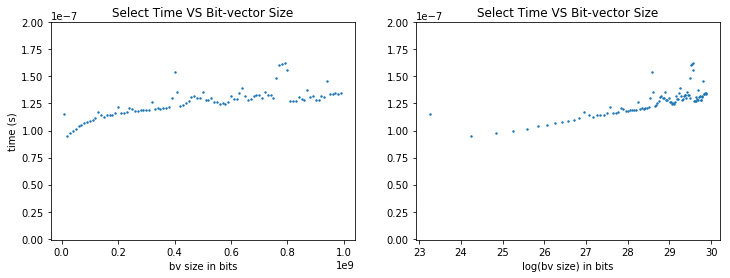

In [60]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(selectStat['bv_size'], selectStat['avg_select_time'], s=2)
plt.title('Select Time VS Bit-vector Size')
plt.xlabel('bv size in bits')
plt.ylabel('time (s)')
plt.ylim((-0.000000001, 0.0000002))
plt.subplot(1,2,2)
plt.scatter(np.log2(selectStat['bv_size']), selectStat['avg_select_time'], s=2)
plt.title('Select Time VS Bit-vector Size')
plt.xlabel('log(bv size) in bits')
plt.ylim((-0.000000001, 0.0000002))


You can run the command for this report as following:
```
> ./bvOperators report -t select -p console
```
If you want to store the results in a file, provide the parent directory path after `-p` rather than the keyword `console`.
```
> ./bvOperators report -t select -p <par_dir>
```
There are 3 options available for report sub-command to set minimum, maximum, and jump size for different bit-vectors that rank is going to be tested on.

# Task3
In this section, I constructed the wavelet tree based on the serialized algorithm that was explained in the paper
"*Simple, Fast and Lightweight Parallel Wavelet Tree Construction*" and stored it in the Level-Wise Wavelet Tree data structure
which is a bit-vector containing all the bits required to store different levels of the tree.
What I store at the end is the wavelet tree bit-vector in binary format, count of unique characters, list of the characters in sorted order,
each of a size of byte and the original sequence length in number of characters.

The construction Memory for my algorithm small and limited to the fixed buffer size that I read from the file and put there
plus the start position vector. I don't load the whole file all at once into memory and read and process it buffer by buffer.
For that reason, I have two passes over the file, but based on a few engineering tweaks I managed to only read the file twice and
construct the whole tree. I also don't store the last level of the tree which is all *0*s as each block
belongs to one single character (or no characters) at that level and hence there is no distinction required between
characters ending up in left and right branch. I also don't store the block start positions in file as it can be
reconstructed easily every time that we load the index.

For improving query time (access, rank, and select) every time that I load the index in addition to constructing
the vector of start positions for each block, I also keep a vector of rank of *1* at the start position of
each block. That saves a bunch of bitwise rank queries required in each of the character query processes
along the tree and although it does not affect the asymptotics of the query time, it helps reduce the constant
value and make the processes faster in trade for a small amount of memory. There is one more interesting 
engineering I did for improving the select performance on the wavelet tree too.
At each level, when we want to call a select which later calls a binary search using rank, 
I instead directly call the binary search with the manual start and end positions
 being the start and end position for the block I'm looking into.
 In this way, at each level, rather than doing a binary search over a sequence of size n
 which in total costs $\mathcal{O}(nlog(\sigma))$,
 I do the search over a sequence of approximate length ~$n/2^{level}$. 

The trickiest part in this task for me was understanding and later implementing the process of
selecting the smallest index `idx` that a character *c* occurs *s* time up to that index.
It was challenging because unlike rank that narrows as we go down the levels of the tree
and makes it possible to walk the tree top-down, in select, we need to start from the lowest level
which is actually the level that each character belongs to a single block and then walk up the tree.

In [67]:
## generate random files with different alphabet size
import string
alphabets = string.printable
print(len(alphabets))
print(alphabets)
import random

100
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



## Preparing the inputs for the experiment

#### Files of the same size (~1M) with alphabet size from 2 to 100

In [78]:
for i in range(2, 101):
    print(i, end="\r")
    f = open("/mnt/scratch1/fatemeh/courses/cmsc858/hw1/wv_files/"+str(i) , "w")
    lst = random.sample(alphabets, i)
    a = random.sample(lst*1000000, 1000000)
    f.write(''.join(a))
    f.close()

#### Files with the same list of alphabet (50) with various sequence length between 1k to 1M (jump size of 100k)

In [84]:
lst = random.sample(alphabets, 50)
lst = lst*1000000
random.shuffle(lst)

In [89]:
len(np.unique(lst[0:1000]))

50

In [87]:
for i in range(1000, 1000000, 100000):
    print(i, end="\r")
    f = open("/mnt/scratch1/fatemeh/courses/cmsc858/hw1/wv_files_variousSize/"+str(i)+"_50chars" , "w")
    f.write(''.join(lst[0:i]))
    f.close()

## Time Analysis for WV Tree Construction, Rank, and Query over different BV sizes with the same list of 50 characters

* The experiment was conducted over 10 samples, range from 1000 chars to less than 1000,000 with jumps of 100,000
* For rank and select, I go over each of the 50 characters and for each I run 10 operations. The time provided is the average over all ~500 rank/select operations
* The construction time seems to be linear as it is expected.
* The rank on wv for smaller BVs takes longer. Cannot explain that. Could be the effect of some sort of caching (which I doubt).
* The select, however, seems to grow close to linear wrt the input size. I would claim this can come up with the few engineering tweaks that I applied to the code. As I said, I don't expect them to change the Asymptotics of the runtime, but since log(n) is already not very big for even sequences of size 1M, I would claim that the two tweaks of limiting the binary search to only one block per level and keeping ranks and positions of the beginning of the blocks can help reduce the time a lot.

In [92]:
wvStat = pd.read_csv("/mnt/scratch1/fatemeh/courses/cmsc858/hw1/wv_files_variousSize/wvRankSelect.stat", 
                         sep="\t", 
                       dtype={'file_size':np.int32, 
                              'size_in_bytes':np.int32, 
                              'construction_time':np.float64,
                              'avg_rank_time':np.float64, 
                              'avg_select_time':np.float64
                             });
print('total # of experiments: {}'.format(len(wvStat)))
wvStat.head()

total # of experiments: 10


,file_size,size_in_bytes,construction_time,avg_rank_time,avg_select_time
0,1000,752,0.001151,9.148020e-07,0.000001
1,101000,75752,0.062651,6.737360e-07,0.000003
2,201000,150752,0.087670,5.270760e-07,0.000002
3,301000,225752,0.121327,5.286290e-07,0.000002
4,401000,300752,0.161528,5.244090e-07,0.000002


Text(0, 0.5, 'wv size (byte)')

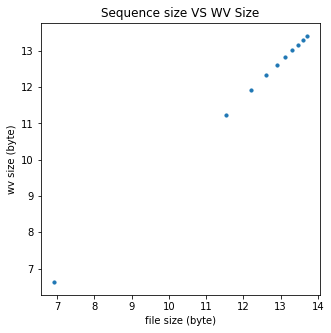

In [109]:
plt.figure(figsize=(5,5))
plt.scatter(np.log(wvStat['file_size']), np.log(wvStat['size_in_bytes']), s=10)
plt.title('Sequence size VS WV Size')
plt.xlabel('file size (byte)')
plt.ylabel('wv size (byte)')

(-1e-09, 5e-06)

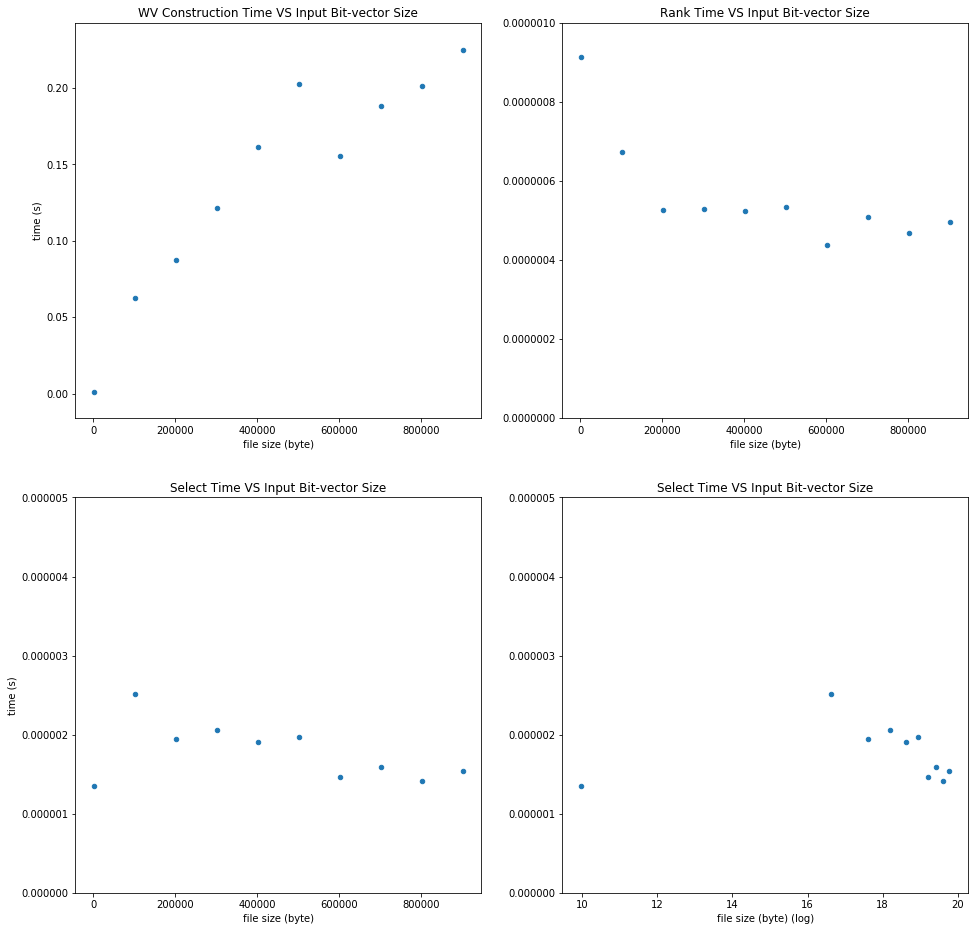

In [101]:
csiz=20
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.scatter(wvStat['file_size'], wvStat['construction_time'], s=csiz)
plt.title('WV Construction Time VS Input Bit-vector Size')
plt.xlabel('file size (byte)')
plt.ylabel('time (s)')
# plt.ylim((-0.000000001, 0.0000002))
plt.subplot(2,2,2)
plt.scatter(wvStat['file_size'], wvStat['avg_rank_time'], s=csiz)
plt.title('Rank Time VS Input Bit-vector Size')
plt.xlabel('file size (byte)')
plt.ylim((-0.000000001, 0.000001))
plt.subplot(2,2,3)
plt.scatter(wvStat['file_size'], wvStat['avg_select_time'], s=csiz)
plt.title('Select Time VS Input Bit-vector Size')
plt.xlabel('file size (byte)')
plt.ylabel('time (s)')
plt.ylim((-0.000000001, 0.000005))
plt.subplot(2,2,4)
plt.scatter(np.log2(wvStat['file_size']), wvStat['avg_select_time'], s=csiz)
plt.title('Select Time VS Input Bit-vector Size')
plt.xlabel('file size (byte) (log)')
plt.ylim((-0.000000001, 0.000005))

## Time Analysis for WV Tree Construction, Rank, and Query over 30 BVs with similar sizes of 1MB but different alphabet count

* The experiment was conducted over 31 samples, all of size 1M characters, but with ranges of 2 to 30 unique characters per each file
* The construction time amazingly depends on the # of unique characters (as expected based on the construction scheme adopted from the paper I mentioned earlier) and it seems to beautifully have this change of behavior over blocks of character count, specifically the obvious proportionate with $log(|\sigma|)$ .
* The rank time also has this $log(|\sigma|)$ behavior since it is linear wrt the sequence size but we require one rank per level of the tree which are in total $log(|\sigma|)$.
* The select, however, again has this weird sort of linear behavior!! Again I claim it's for the tricks!!

In [105]:
wvStat2 = pd.read_csv("/mnt/scratch1/fatemeh/courses/cmsc858/hw1/wv_files/wvRankSelect.stat", 
                         sep="\t", 
                       dtype={'alphabet_size':np.int32, 
                              'size_in_bytes':np.int32, 
                              'construction_time':np.float64,
                              'avg_rank_time':np.float64, 
                              'avg_select_time':np.float64
                             });
print('total # of experiments: {}'.format(len(wvStat2)))
wvStat2.head()

total # of experiments: 31


,alphabet_size,size_in_bytes,construction_time,avg_rank_time,avg_select_time
0,2,125000,0.064328,1.800000e-07,0.000002
1,3,250000,0.070889,2.054670e-07,0.000003
2,4,250000,0.071566,2.130500e-07,0.000002
3,5,375000,0.093194,2.980400e-07,0.000003
4,6,375000,0.096749,2.933170e-07,0.000002


(-1e-09, 5e-06)

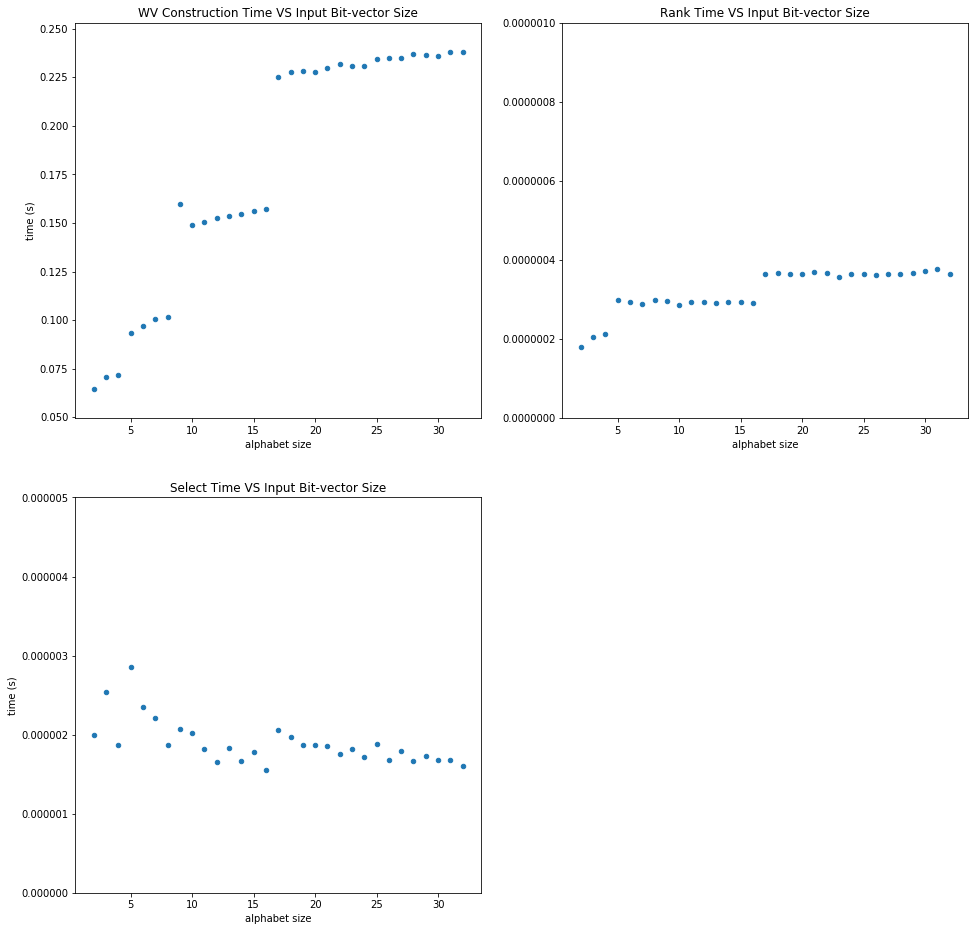

In [107]:
csiz=20
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.scatter(wvStat2['alphabet_size'], wvStat2['construction_time'], s=csiz)
plt.title('WV Construction Time VS Input Bit-vector Size')
plt.xlabel('alphabet size')
plt.ylabel('time (s)')
# plt.ylim((-0.000000001, 0.0000002))
plt.subplot(2,2,2)
plt.scatter(wvStat2['alphabet_size'], wvStat2['avg_rank_time'], s=csiz)
plt.title('Rank Time VS Input Bit-vector Size')
plt.xlabel('alphabet size')
plt.ylim((-0.000000001, 0.000001))
plt.subplot(2,2,3)
plt.scatter(wvStat2['alphabet_size'], wvStat2['avg_select_time'], s=csiz)
plt.title('Select Time VS Input Bit-vector Size')
plt.xlabel('alphabet size')
plt.ylabel('time (s)')
plt.ylim((-0.000000001, 0.000005))

Since I am putting all of these as one executable, the commands interfaces are a little bit
different from what the professor has specifically asked but they answer the same queries and
build process that is required in the homework.
In the following lines, I bring a few examples of different sub-commands for constructing and querying the wavelet tree.

To construct the wavelet tree, we require two inputs, the input file containing the sequence `<input>`
and the address pointing to the directory we will store the index in, `<idx_par_dir>`.

```
> ./bvOperators wv_build -i <input> -p <idx_par_dir>
```

To call different queries of <access, rank, and select> on the wavelet tree,
we require two main inputs, the query file `<qfile>` and the index directory `<idx_par_dir>`
in addition to specifying the type of the query.
```
> ./bvOperators wv -t <access/rank/select> -p <par_dir> -i <qfile>
```